In [2]:
# Initial imports
import os
import folium
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt

from branca.colormap import linear
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from pprint import pprint

In [3]:
# Psycopg2 is a popular PostgreSQL adapter for the Python programming language. It allows Python code to interact with PostgreSQL databases. 
import psycopg2
from psycopg2 import sql

# Import the time module so we can time our queries.
import time

# Amazon SageMaker and related imports
import sagemaker
import sagemaker.amazon.common as smac
from sagemaker.deserializers import JSONDeserializer
from sagemaker.serializers import CSVSerializer
from sagemaker import get_execution_role
from sagemaker import image_uris
import boto3  # AWS Python sdk

%matplotlib inline

sagemaker.config INFO - Not applying SDK defaults from location: C:\ProgramData\sagemaker\sagemaker\config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: C:\Users\Fer\AppData\Local\sagemaker\sagemaker\config.yaml


In [4]:
#Info for the connection wiht postgres SQL in RDS
PGEND_POINT = 'database-1.cfwmkaw8o6bp.us-east-1.rds.amazonaws.com' #End Point
PGDATABASE_NAME ='heart_attack_prediction_db' #data base name 
PGUSER_NAME = 'postgres'
PGPASSWORD = 'B00TC4MP'

In [5]:
#Defining functions for connection and close connection
def connect():
    conn_string = f"host={PGEND_POINT} port=5432 dbname={PGDATABASE_NAME} user={PGUSER_NAME} password={PGPASSWORD}"
    conn = psycopg2.connect(conn_string)
    print("Connected!")
    
    #Create a cursor object
    cursor = conn.cursor()
    
    return conn, cursor

#Close connection function definition
def close_connection(conn, cursor):
    conn.commit()
    cursor.close()
    conn.close()
    print("Connection closed.")

In [6]:
#Creting the connection with postgres SQL
conn, cursor = connect()

Connected!


In [7]:
#SQL SELECT statement that retrieves all columns (*) from the table named heartattackprediction.
query_hat_all = sql.SQL("""
SELECT * FROM heartattackcapitals;
""")

In [8]:
#Preparation of the database cursor to execute the SQL query specified by query_hat_all. 
#Once the query is executed, the cursor will hold the result set (if any) 
#returned by the database server.
cur = conn.cursor()
cur.execute(query_hat_all)

In [9]:
#put all the data in heartattackprediction table into a data frame in pandas all the columns name appear
pd_df = pd.DataFrame(cur.fetchall(), columns=['Country','Capital','Patient ID', 'Age', 'Sex','Cholesterol','Heart Rate','Diabetes','Family History','Smoking','Obesity','Alcohol Consumption','Exercise Hours Per Week','Diet','Previous Heart Problems','Medication Use','Stress Level','Sedentary Hours Per Day','Income','BMI','Triglycerides','Physical Activity Days Per Week','Sleep Hours Per Day','Continent','Hemisphere','Heart Attack Risk', 'lat', 'long', 'systolic preassure','diastolic preassure'])
pd_df

,Country,Capital,Patient ID,Age,Sex,Cholesterol,Heart Rate,Diabetes,Family History,Smoking,...,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Continent,Hemisphere,Heart Attack Risk,lat,long,systolic preassure,diastolic preassure
0,Argentina,Buenos Aires,BMW7812,67,1,208,72,0,0,1,...,286,0,6,South America,1,0,-34.0,-64.0,158,88
1,Argentina,Buenos Aires,SLE3369,27,0,135,49,1,1,0,...,297,1,10,South America,1,1,-34.0,-64.0,120,77
2,Argentina,Buenos Aires,IUJ5442,27,0,263,83,0,1,0,...,411,2,9,South America,1,0,-34.0,-64.0,127,109
3,Argentina,Buenos Aires,BSV5917,29,0,201,86,0,0,0,...,785,0,10,South America,1,0,-34.0,-64.0,134,60
4,Argentina,Buenos Aires,QWD3129,51,1,197,79,1,1,1,...,785,1,5,South America,1,0,-34.0,-64.0,106,106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8758,Vietnam,Hanoi,QWP9633,88,1,394,51,1,0,1,...,79,7,9,Asia,0,0,16.0,106.0,112,62
8759,Vietnam,Hanoi,AZG4713,45,0,368,87,1,0,1,...,564,2,5,Asia,0,0,16.0,106.0,180,94
8760,Vietnam,Hanoi,WAO3408,85,1,200,65,1,1,1,...,214,1,10,Asia,0,1,16.0,106.0,167,101
8761,Vietnam,Hanoi,WFO1019,29,1,280,90,1,1,1,...,423,5,5,Asia,0,0,16.0,106.0,106,107


In [10]:
data_df = pd_df
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8763 entries, 0 to 8762
Data columns (total 30 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          8763 non-null   object 
 1   Capital                          8763 non-null   object 
 2   Patient ID                       8763 non-null   object 
 3   Age                              8763 non-null   int64  
 4   Sex                              8763 non-null   object 
 5   Cholesterol                      8763 non-null   int64  
 6   Heart Rate                       8763 non-null   int64  
 7   Diabetes                         8763 non-null   int64  
 8   Family History                   8763 non-null   int64  
 9   Smoking                          8763 non-null   int64  
 10  Obesity                          8763 non-null   int64  
 11  Alcohol Consumption              8763 non-null   int64  
 12  Exercise Hours Per W

In [11]:
mean_chol_continent = data_df.groupby('Continent')['Cholesterol'].mean()
chol_continent = pd.DataFrame(mean_chol_continent).reset_index()

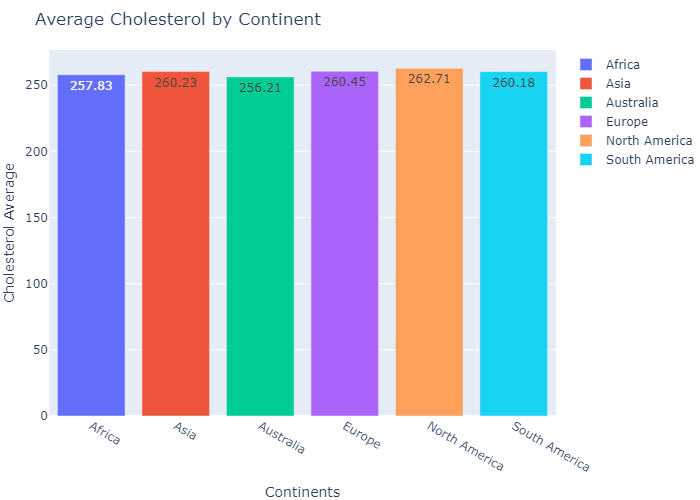

In [12]:
# Processing the data
visuals = []
for index, row in chol_continent.iterrows():
    visuals.append(
        go.Bar(
            name=row['Continent'],
            x=[row['Continent']],  # Using a list for x to make it a column-like representation
            y=[row['Cholesterol']],  # Using a list for y to make it a column-like representation
            text=[f"{row['Cholesterol']:.2f}"],  # Displaying values with two decimal places
            textposition='auto',  # Automatically position the text on
            showlegend=True,
        )
    )

# Establishing the axis titles
layout = go.Layout(
    title="Average Cholesterol by Continent",
    xaxis=dict(
        title="Continents"
    ),
    yaxis=dict(
        title="Cholesterol Average",
    )
)

# Establishing the figure margins
vis = go.Figure(visuals, layout=layout)
vis.update_layout(
    margin=go.layout.Margin(
        l=0,  # left margin
        r=0,  # right margin
        b=0,  # bottom margin
        t=50   # top margin  <- Need to be adjusted if title is added!
    )
)

# Creating a new directory if not exists
os.makedirs("results/", exist_ok=True)

# Saving results image as a png file
vis.show(renderer="png")
vis.write_image("results/heart_attack_rates_2.png")

In [13]:
mean_tri_continent = data_df.groupby('Continent')['Triglycerides'].mean()
tri_continent = pd.DataFrame(mean_tri_continent).reset_index()

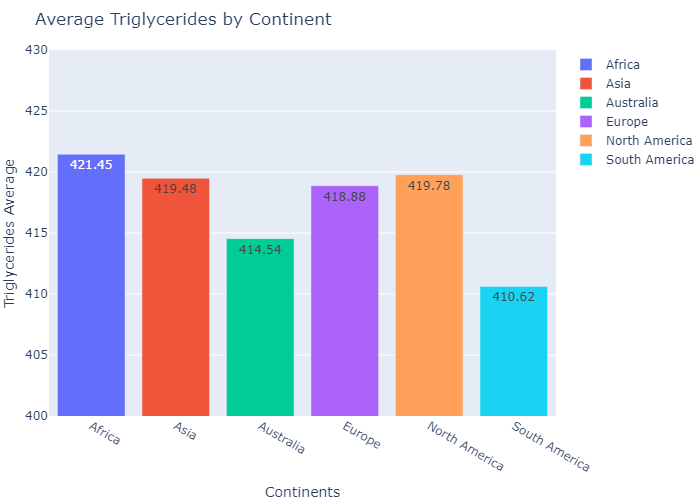

In [14]:
# Processing the data
visuals = []
for index, row in tri_continent.iterrows():
    visuals.append(
        go.Bar(
            name=row['Continent'],
            x=[row['Continent']],  # Using a list for x to make it a column-like representation
            y=[row['Triglycerides']],  # Using a list for y to make it a column-like representation
            text=[f"{row['Triglycerides']:.2f}"],  # Displaying values with two decimal places
            textposition='auto',  # Automatically position the text on
            showlegend=True,
        )
    )

# Establishing the axis titles
layout = go.Layout(
    title="Average Triglycerides by Continent",
    xaxis=dict(
        title="Continents"
    ),
    yaxis=dict(
        title="Triglycerides Average",
        range=[400, 430]
    )
)

# Establishing the figure margins
vis = go.Figure(visuals, layout=layout)
vis.update_layout(
    margin=go.layout.Margin(
        l=0,  # left margin
        r=0,  # right margin
        b=0,  # bottom margin
        t=50   # top margin  <- Need to be adjusted if title is added!
    )
)

# Creating a new directory if not exists
os.makedirs("results/", exist_ok=True)

# Saving results image as a png file
vis.show(renderer="png")
vis.write_image("results/heart_attack_rates.png")

In [15]:
chol_tri_continent = pd.merge(tri_continent, chol_continent, on='Continent', how='inner')
chol_tri_continent.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Continent      6 non-null      object 
 1   Triglycerides  6 non-null      float64
 2   Cholesterol    6 non-null      float64
dtypes: float64(2), object(1)
memory usage: 272.0+ bytes


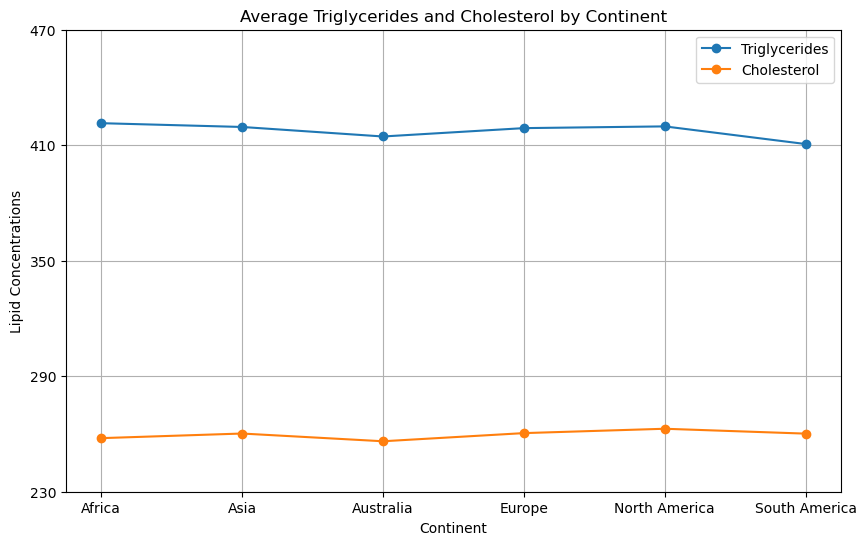

In [16]:
# Plotting the double line graph
axis = chol_tri_continent.plot(x='Continent', y=['Triglycerides', 'Cholesterol'], kind='line', marker='o')

# Adding labels and title
plt.xlabel('Continent')
plt.ylabel('Lipid Concentrations')
plt.title('Average Triglycerides and Cholesterol by Continent')

#Changing the scale of the graph
plt.gcf().set_size_inches(10, 6) 
axis.yaxis.set_ticks([230, 290, 350, 410, 470])
axis.set_xticks(chol_tri_continent.index)
axis.grid(True)

# Display the plot
plt.savefig('results/lipids.png')
plt.show()

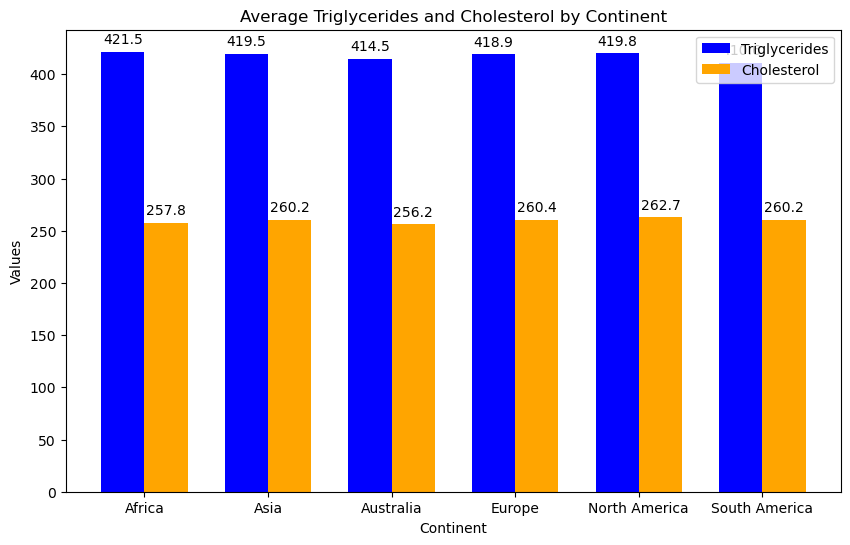

In [17]:
# Creating a double bar graph for Triglycerides and Cholesterol
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.35  # Width of each bar
index = np.arange(len(chol_tri_continent['Continent']))

# Bar graph for Triglycerides
ax.bar(index, chol_tri_continent['Triglycerides'], width=bar_width, label='Triglycerides', color='blue')

# Bar graph for Cholesterol
ax.bar(index + bar_width, chol_tri_continent['Cholesterol'], width=bar_width, label='Cholesterol', color='orange')

# Adding values on top of each bar
for i, value in enumerate(chol_tri_continent['Triglycerides']):
    plt.text(i, value + 5, round(value, 1), ha='center', va='bottom', color='black')

for i, value in enumerate(chol_tri_continent['Cholesterol']):
    plt.text(i + bar_width, value + 5, round(value, 1), ha='center', va='bottom', color='black')

# Adding labels and title
ax.set_xlabel('Continent')
ax.set_ylabel('Values')
ax.set_title('Average Triglycerides and Cholesterol by Continent')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(chol_tri_continent['Continent'])
ax.legend()


In [18]:
#Making a df to make the map with folium which requires list inputs since it doesn't take pandas dataframes
selected_columns = ['Capital', 'lat', 'long', 'Triglycerides', 'Cholesterol']
tri_chol_map_df = pd_df[selected_columns]
tri_chol_map_df

#Cleaning up
average_tri_map = tri_chol_map_df.groupby('Capital')['Cholesterol'].mean()
average_chol_map = tri_chol_map_df.groupby('Capital')['Triglycerides'].mean()
average_lipids = pd.merge(average_chol_map, average_tri_map, on = 'Capital', how = 'inner')

average_location_lat = tri_chol_map_df.groupby('Capital')['lat'].mean()
average_location_long = tri_chol_map_df.groupby('Capital')['long'].mean()
average_location = pd.merge(average_location_lat, average_location_long, on = 'Capital', how = 'inner')


tri_chol_map_df = pd.merge(average_lipids, average_location, on = 'Capital', how = 'inner')
tri_chol_map_df


,Triglycerides,Cholesterol,lat,long
Capital,,,,
Abuja,425.395089,262.205357,10.0000,8.0000
Bangkok,429.883178,262.137850,15.0000,100.0000
Beijing,413.323394,258.009174,35.0000,105.0000
Berlin,416.528302,258.060797,51.0000,9.0000
Bogota,405.522145,261.846154,4.0000,-72.0000
Brasilia,406.000000,257.270563,-10.0000,-55.0000
Buenos Aires,419.785563,261.520170,-34.0000,-64.0000
Canberra,419.879733,258.997773,-27.0000,133.0000
Hanoi,430.327059,264.418824,16.0000,106.0000


In [19]:
heart_trichol= tri_chol_map_df.to_dict()
heart_trichol

{'Triglycerides': {'Abuja': 425.3950892857143,
  'Bangkok': 429.88317757009344,
  'Beijing': 413.32339449541286,
  'Berlin': 416.52830188679246,
  'Bogota': 405.5221445221445,
  'Brasilia': 406.0,
  'Buenos Aires': 419.7855626326964,
  'Canberra': 419.87973273942094,
  'Hanoi': 430.3270588235294,
  'London': 419.6017505470459,
  'Madrid': 409.66511627906976,
  'New Delhi': 396.5194174757282,
  'Ottawa': 406.05227272727274,
  'Paris': 434.23766816143495,
  'Pretoria': 417.2917647058824,
  'Rome': 414.02088167053364,
  'Seoul': 420.09290953545235,
  'Tokyo': 426.0323325635104,
  'Washington': 434.1666666666667,
  'Wellington': 409.0206896551724},
 'Cholesterol': {'Abuja': 262.20535714285717,
  'Bangkok': 262.1378504672897,
  'Beijing': 258.0091743119266,
  'Berlin': 258.0607966457023,
  'Bogota': 261.84615384615387,
  'Brasilia': 257.2705627705628,
  'Buenos Aires': 261.52016985138005,
  'Canberra': 258.9977728285078,
  'Hanoi': 264.4188235294118,
  'London': 259.8336980306346,
  'Madrid

In [20]:
my_map = folium.Map(location=[27.2546, 33.8116], zoom_start=2.3)

# Add markers for each city with popup showing cholesterol and triglycerides information
for city, lat in heart_trichol['lat'].items():
    long = heart_trichol['long'][city]
    cholesterol = heart_trichol['Cholesterol'][city]
    triglycerides = heart_trichol['Triglycerides'][city]

    popup_content = f'<b>{city}</b><br>Cholesterol: {cholesterol}<br>Triglycerides: {triglycerides}'
    folium.Marker(location=[lat, long], popup=popup_content).add_to(my_map)

# Save the map to an HTML file
my_map.save("cholesterol_triglycerides_map.html")

In [27]:
# Get all countries
all_countries = list(heart_trichol['lat'].keys())

# Create a base map centered on the world
world_map = folium.Map(location=[0, 0], zoom_start=2)

# Create a feature group for top triglycerides layer
triglycerides_layer = folium.FeatureGroup(name='Top 3 Triglycerides')

for city, value in sorted(heart_trichol['Triglycerides'].items(), key=lambda x: x[1], reverse=True)[:3]:
    folium.Marker(location=[heart_trichol['lat'][city], heart_trichol['long'][city]],
                popup=f'Triglycerides: {value}',
                icon=folium.Icon(color='blue')).add_to(triglycerides_layer)

# Create a feature group for top cholesterol layer
cholesterol_layer = folium.FeatureGroup(name='Top 3 Cholesterol')

for city, value in sorted(heart_trichol['Cholesterol'].items(), key=lambda x: x[1], reverse=True)[:3]:
    folium.Marker(location=[heart_trichol['lat'][city], heart_trichol['long'][city]],
                popup=f'Cholesterol: {value}',
                icon=folium.Icon(color='red')).add_to(cholesterol_layer)

# Create a feature group for all countries layer
all_countries_layer = folium.FeatureGroup(name='All Countries')

for city in all_countries:
    folium.Marker(location=[heart_trichol['lat'][city], heart_trichol['long'][city]],
                popup=f'Triglycerides: {heart_trichol["Triglycerides"].get(city, "N/A")}, Cholesterol: {heart_trichol["Cholesterol"].get(city, "N/A")}',
                icon=folium.Icon(color='green')).add_to(all_countries_layer)

# Add layers to the map
triglycerides_layer.add_to(world_map)
cholesterol_layer.add_to(world_map)
all_countries_layer.add_to(world_map)

# Add layer control
folium.LayerControl().add_to(world_map)

# Save or display the map
world_map.save('layer_map.html')